# Import Libraries

In [49]:
import cv2
import os
from craft_text_detector import Craft
import math
import numpy as np
import matplotlib.pyplot as plt

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import pytesseract

Ultralytics YOLOv8.0.132  Python-3.8.17 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 960M, 4096MiB)
Setup complete  (8 CPUs, 15.8 GB RAM, 175.3/238.5 GB disk)


# Tesseract

In [50]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 3 --psm 12 '

# Load Model

In [40]:
craft = Craft( crop_type="box", cuda=True, text_threshold=0.5, link_threshold=0.5, low_text=.5)

# Tightness using open-cv

In [41]:
def get_bounding_boxes(box):
    flat_box = box.flatten()
    x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
    y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
    x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
    y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

    return x_min,y_min,x_max,y_max

3
Total Tightness: 375273.0


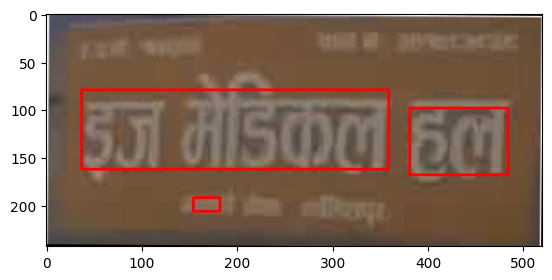

In [51]:

# Load the image
image_path = 'segmentation/nep_board.png'
image = cv2.imread(image_path)

# Preprocess the image
# Apply resizing, noise reduction, thresholding, etc.

# Find contours in the image

boxes = craft.detect_text(image)['boxes']

# Get angled boxes and rotate
angled_boxes = []

        # Get angled boxes
for box in boxes:
    if len(box) >= 3:  # Ensure at least 3 points for a polygon
        # Convert box points to numpy array for easier manipulation
        box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

        # Calculate the minimum bounding rectangle
        rotated_rect = cv2.minAreaRect(box_points)
        box_vertices = cv2.boxPoints(rotated_rect)
        box_vertices = np.int0(box_vertices)
        angled_boxes.append(box_vertices)
try:
    # Get largest contour and rotate on basis of that
    largest_contour = max(angled_boxes, key=cv2.contourArea)
    rows,cols = image.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(largest_contour, cv2.DIST_L2,0,0.01,0.01)
    lefty = (-x*vy/vx) + y
    righty = ((cols-x)*vy/vx)+y

    angle_rad = np.arctan2(vy, vx)
    angle = np.degrees(angle_rad)[0]

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    
    if angle != 90:
        rotation_matrix = cv2.getRotationMatrix2D(center, angle , scale=1.0)
        image = cv2.warpAffine(image, rotation_matrix , (width, height))   
except:
    pass

image_rect = image.copy()

# Check tightness
boxes = craft.detect_text(image)['boxes']

total_tightness = 0
for box in boxes:
    x_min,y_min,x_max,y_max = get_bounding_boxes(box)
    roi = image[y_min : y_max , x_min : x_max].copy()
    image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_max,y_max), (255,0,0), 2)
    gray_inverted = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray_inverted, 50, 225, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter out small contours (adjust the min_area threshold as needed)
    min_area = 100  # Example threshold, adjust as needed
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

    # Calculate total tightness (sum of areas of bounding rectangles)
    total_tightness += sum(cv2.contourArea(contour) for contour in filtered_contours)

plt.imshow(image_rect)
print(len(boxes))

print(f"Total Tightness: {total_tightness}")


# Get Number of boxes